# Dashboard de Otimização de Consumo
## Visualizações e Recomendações

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from datetime import datetime

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
%matplotlib inline

print(' Dashboard inicializado!')

 Dashboard inicializado!


In [2]:
# Carregar dados
conn = sqlite3.connect('../data/energia.db')
df_consumo = pd.read_sql_query('SELECT * FROM consumo', conn)
df_consumidores = pd.read_sql_query('SELECT * FROM consumidores', conn)
df_tarifas = pd.read_sql_query('SELECT * FROM tarifas', conn)
df_picos = pd.read_sql_query('SELECT * FROM picos', conn)
conn.close()

df_consumo['data_hora'] = pd.to_datetime(df_consumo['data_hora'])
df_picos['data_hora'] = pd.to_datetime(df_picos['data_hora'])
df_merged = df_consumo.merge(df_consumidores, on='id_consumidor')
df_merged = df_merged.merge(df_tarifas, on='id_tarifa')

## Dashboard Principal

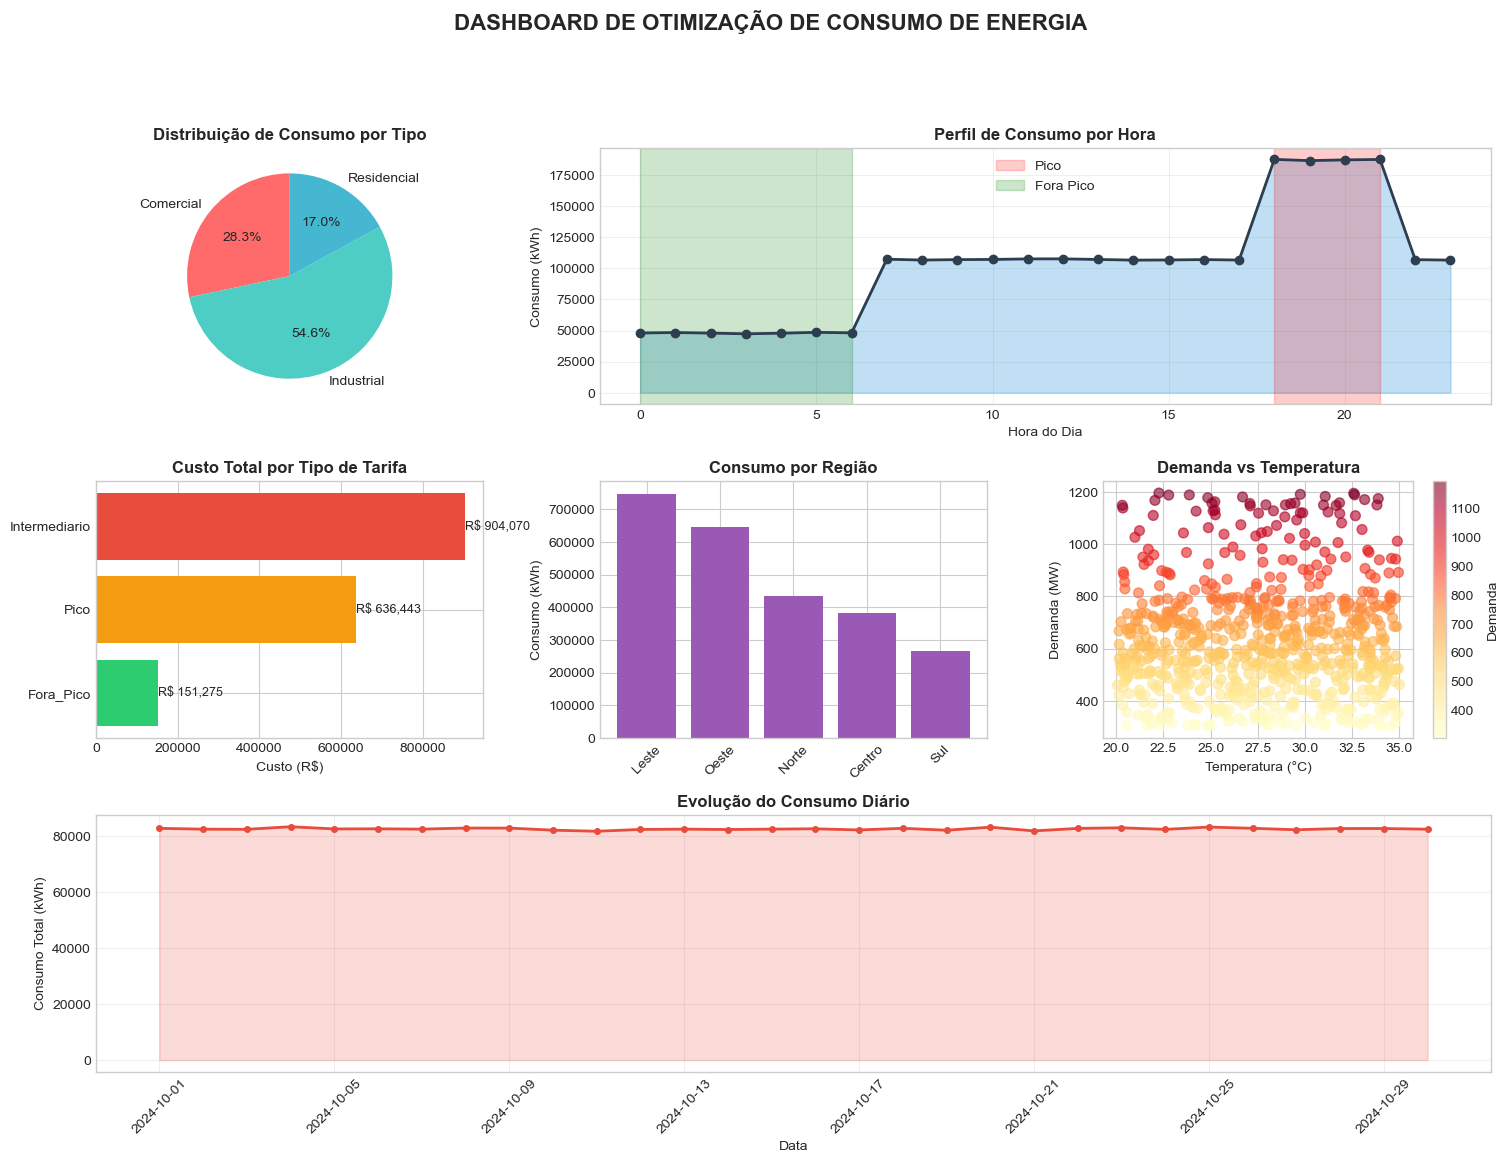

In [3]:
# Criar dashboard completo
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Consumo por Tipo de Consumidor
ax1 = fig.add_subplot(gs[0, 0])
consumo_tipo = df_merged.groupby('tipo_consumidor')['consumo_kwh'].sum()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
ax1.pie(consumo_tipo, labels=consumo_tipo.index, autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title('Distribuição de Consumo por Tipo', fontweight='bold', fontsize=12)

# 2. Consumo por Hora
ax2 = fig.add_subplot(gs[0, 1:])
df_merged['hora'] = df_merged['data_hora'].dt.hour
consumo_hora = df_merged.groupby('hora')['consumo_kwh'].sum()
ax2.fill_between(consumo_hora.index, consumo_hora.values, alpha=0.3, color='#3498db')
ax2.plot(consumo_hora.index, consumo_hora.values, marker='o', linewidth=2, color='#2c3e50')
ax2.axvspan(18, 21, alpha=0.2, color='red', label='Pico')
ax2.axvspan(0, 6, alpha=0.2, color='green', label='Fora Pico')
ax2.set_title('Perfil de Consumo por Hora', fontweight='bold', fontsize=12)
ax2.set_xlabel('Hora do Dia')
ax2.set_ylabel('Consumo (kWh)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Custo por Tipo de Tarifa
ax3 = fig.add_subplot(gs[1, 0])
custo_tarifa = df_merged.groupby('tipo_horario')['custo_total'].sum().sort_values()
bars = ax3.barh(custo_tarifa.index, custo_tarifa.values, color=['#2ecc71', '#f39c12', '#e74c3c'])
ax3.set_title('Custo Total por Tipo de Tarifa', fontweight='bold', fontsize=12)
ax3.set_xlabel('Custo (R$)')
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax3.text(width, bar.get_y() + bar.get_height()/2, f'R$ {width:,.0f}', 
             ha='left', va='center', fontsize=9)

# 4. Consumo por Região
ax4 = fig.add_subplot(gs[1, 1])
consumo_regiao = df_merged.groupby('regiao')['consumo_kwh'].sum().sort_values(ascending=False)
ax4.bar(consumo_regiao.index, consumo_regiao.values, color='#9b59b6')
ax4.set_title('Consumo por Região', fontweight='bold', fontsize=12)
ax4.set_ylabel('Consumo (kWh)')
ax4.tick_params(axis='x', rotation=45)

# 5. Demanda vs Temperatura
ax5 = fig.add_subplot(gs[1, 2])
scatter = ax5.scatter(df_picos['temperatura_celsius'], df_picos['demanda_total_mw'], 
                     c=df_picos['demanda_total_mw'], cmap='YlOrRd', alpha=0.6, s=50)
ax5.set_title('Demanda vs Temperatura', fontweight='bold', fontsize=12)
ax5.set_xlabel('Temperatura (°C)')
ax5.set_ylabel('Demanda (MW)')
plt.colorbar(scatter, ax=ax5, label='Demanda')

# 6. Evolução do Consumo Diário
ax6 = fig.add_subplot(gs[2, :])
df_merged['data'] = df_merged['data_hora'].dt.date
consumo_diario = df_merged.groupby('data')['consumo_kwh'].sum()
ax6.plot(consumo_diario.index, consumo_diario.values, linewidth=2, color='#e74c3c', marker='o', markersize=4)
ax6.fill_between(consumo_diario.index, consumo_diario.values, alpha=0.2, color='#e74c3c')
ax6.set_title('Evolução do Consumo Diário', fontweight='bold', fontsize=12)
ax6.set_xlabel('Data')
ax6.set_ylabel('Consumo Total (kWh)')
ax6.grid(True, alpha=0.3)
ax6.tick_params(axis='x', rotation=45)

plt.suptitle('DASHBOARD DE OTIMIZAÇÃO DE CONSUMO DE ENERGIA', 
             fontsize=16, fontweight='bold', y=0.995)

plt.show()

## Métricas Principais (KPIs)

In [7]:
# Calcular KPIs principais
consumo_total = df_consumo['consumo_kwh'].sum()
custo_total = df_consumo['custo_total'].sum()
consumo_medio = df_consumo['consumo_kwh'].mean()
num_consumidores = df_consumidores['id_consumidor'].nunique()

# Consumo em horário de pico
consumo_pico = df_merged[df_merged['tipo_horario'] == 'Pico']['consumo_kwh'].sum()
percentual_pico = (consumo_pico / consumo_total) * 100

# Economia potencial
tarifa_pico = df_tarifas[df_tarifas['tipo_horario'] == 'Pico']['valor_kwh'].values[0]
tarifa_fora_pico = df_tarifas[df_tarifas['tipo_horario'] == 'Fora_Pico']['valor_kwh'].values[0]
economia_potencial = consumo_pico * (tarifa_pico - tarifa_fora_pico)

# Exibir KPIs
print('='*60)
print(' INDICADORES PRINCIPAIS (KPIs)')
print('='*60)
print(f'\n Consumo Total: {consumo_total:,.2f} kWh')
print(f' Custo Total: R$ {custo_total:,.2f}')
print(f' Consumo Médio: {consumo_medio:.2f} kWh')
print(f' Total de Consumidores: {num_consumidores}')
print(f'\n Consumo em Horário de Pico: {consumo_pico:,.2f} kWh ({percentual_pico:.1f}%)')
print(f' Economia Potencial: R$ {economia_potencial:,.2f}')
print('='*60)

 INDICADORES PRINCIPAIS (KPIs)

 Consumo Total: 2,475,800.89 kWh
 Custo Total: R$ 1,691,787.95
 Consumo Médio: 34.39 kWh
 Total de Consumidores: 100

 Consumo em Horário de Pico: 748,757.34 kWh (30.2%)
 Economia Potencial: R$ 299,502.94


## Recomendações Estratégicas

In [5]:
print('\n' + '='*60)
print(' RECOMENDAÇÕES PARA OTIMIZAÇÃO DE CONSUMO')
print('='*60)

print('\n1. GESTÃO DE HORÁRIOS DE PICO')
print(f'   • {percentual_pico:.1f}% do consumo ocorre em horário de pico')
print(f'   • Reduzir 30% do consumo de pico economizaria R$ {economia_potencial * 0.3:,.2f}')
print('   • Ação: Implementar programa de incentivo para consumo fora de pico')

print('\n2. SEGMENTAÇÃO POR TIPO DE CONSUMIDOR')
consumo_industrial = df_merged[df_merged['tipo_consumidor'] == 'Industrial']['consumo_kwh'].sum()
perc_industrial = (consumo_industrial / consumo_total) * 100
print(f'   • Consumidores industriais: {perc_industrial:.1f}% do consumo total')
print('   • Ação: Oferecer tarifas especiais para consumo noturno industrial')

print('\n3. EFICIÊNCIA ENERGÉTICA')
print('   • Identificar os 10 maiores consumidores em horário de pico')
print('   • Ação: Programa de auditoria energética personalizada')
print('   • Meta: Redução de 15% no consumo de pico em 6 meses')

print('\n4. MONITORAMENTO E ALERTAS')
print('   • Implementar sistema de alertas para consumo anormal')
print('   • Ação: Dashboard em tempo real para consumidores')
print('   • Benefício: Redução de desperdício e maior conscientização')

print('\n5. IMPACTO FINANCEIRO ESTIMADO')
economia_anual = economia_potencial * 12 * 0.3  # 30% de redução em 12 meses
print(f'   • Economia anual potencial: R$ {economia_anual:,.2f}')
print(f'   • ROI estimado: 6-12 meses')
print('='*60)


 RECOMENDAÇÕES PARA OTIMIZAÇÃO DE CONSUMO

1. GESTÃO DE HORÁRIOS DE PICO
   • 30.2% do consumo ocorre em horário de pico
   • Reduzir 30% do consumo de pico economizaria R$ 89,850.88
   • Ação: Implementar programa de incentivo para consumo fora de pico

2. SEGMENTAÇÃO POR TIPO DE CONSUMIDOR
   • Consumidores industriais: 54.6% do consumo total
   • Ação: Oferecer tarifas especiais para consumo noturno industrial

3. EFICIÊNCIA ENERGÉTICA
   • Identificar os 10 maiores consumidores em horário de pico
   • Ação: Programa de auditoria energética personalizada
   • Meta: Redução de 15% no consumo de pico em 6 meses

4. MONITORAMENTO E ALERTAS
   • Implementar sistema de alertas para consumo anormal
   • Ação: Dashboard em tempo real para consumidores
   • Benefício: Redução de desperdício e maior conscientização

5. IMPACTO FINANCEIRO ESTIMADO
   • Economia anual potencial: R$ 1,078,210.57
   • ROI estimado: 6-12 meses


## Exportar Relatório

In [6]:
# Criar relatório resumido
relatorio = {
    'Data_Relatorio': datetime.now().strftime('%Y-%m-%d'),
    'Consumo_Total_kWh': consumo_total,
    'Custo_Total_R$': custo_total,
    'Consumo_Pico_kWh': consumo_pico,
    'Percentual_Pico': percentual_pico,
    'Economia_Potencial_R$': economia_potencial,
    'Num_Consumidores': num_consumidores
}

df_relatorio = pd.DataFrame([relatorio])
df_relatorio.to_csv('../data/processed/relatorio_otimizacao.csv', index=False)

print(' Relatório exportado: data/processed/relatorio_otimizacao.csv')

 Relatório exportado: data/processed/relatorio_otimizacao.csv
